In [3]:
import time
import pandas as pd
import re
import datetime

# Data Loading

In [4]:
# load the csv file into a pandas dataframe
df = pd.read_csv("discord_channel_messages.csv")
df

,author,content,timestamp
0,KILLFEED,"Romanov got killed by DuDeKh (LAR, 4.04m)",2025-04-12T18:33:43.752Z
1,KILLFEED,"ItzKrogzy got killed by M (M4-A1, 5.1m)",2025-04-12T20:39:18.931Z
2,KILLFEED,"Insane got killed by BORIS BRITVA (VSD, 8.61m)",2025-04-12T20:49:39.085Z
3,Unknown,"DerBube got killed by 4fun (LAR, 4.42m)",2025-04-12T20:52:26.855Z
4,KILLFEED,"Abrahamsen got killed by MEDOED (KA-M, 23.21m)",2025-04-12T21:02:59.810Z
...,...,...,...
5174,KILLFEED,"Toshiks got killed by Scorpion (Blaze, 240.38m)",2024-09-17T16:46:03.191Z
5175,KILLFEED,Jimmie Grinney got killed by Klase (CR-550 Sav...,2024-09-17T17:31:57.047Z
5176,Unknown,"[CCCP]kroLik got killed by Quess who? (USG-45,...",2024-09-17T17:36:29.176Z
5177,KILLFEED,prime got killed by [adidas]son of palych (KA-...,2024-09-17T17:55:56.805Z


In [27]:
# load weapons.xlsx
weapons_df = pd.read_excel("weapons.xlsx")
weapons_df

,Weapon,Kill Count,is_gun
0,KA-74,458,True
1,DMR,325,True
2,M70 Tundra,286,True
3,M4-A1,266,True
4,KA-M,244,True
...,...,...,...
106,Glass Bottle,1,False
107,Sharpened Stick,1,False
108,Frying Pan,1,False
109,Venison Steak,1,False


# Data Processing

In [5]:
# load the csv file into a pandas dataframe
df = pd.read_csv("discord_channel_messages.csv")

# drop author column
df.drop(columns=['author'], inplace=True)

# Split column content
# Victim: before the first " got killed by "
# Killer: between " got killed by " and " "
# Meter: after ", " and before "m)"

df['Victim'] = df['content'].str.extract(r'^(.*?) got killed by ')

# if Victim contains "Survivor (<any number>)" set the String to "User"
df['Victim'] = df['Victim'].str.replace(r'Survivor \(\d+\)', 'Survivor', regex=True)


# tmp: everything after 'got killed by '
df['tmp2'] = df['content'].str.split('got killed by ').str[1]


df['Meter'] = df['content'].str.extract(r', (.*?)m\)')

# TMP: reverse the order of the characters in colmn content
df['tmp'] = df['content'].str[::-1]
# keep everything after the first " ," 
df['tmp'] = df['tmp'].str.split(' ,').str[1]
# remove everything behind the first "( " with regex
df['tmp'] = df['tmp'].str.replace(r'\(.*', '', regex=True)
# reverse the order of the characters in column tmp again
df['Weapon'] = df['tmp'].str[::-1]
# split the column tmp2 by " (". Sometimes there are two " (" in the column in this case we combine [0] and [1]
df['Killer'] = df['tmp2'].str.split(' \(').str[0]
# drop the column tmp2
df.drop(columns=['tmp'], inplace=True)
df.drop(columns=['tmp2'], inplace=True)


# drop the column content
df.drop(columns=['content'], inplace=True)

# create column date and column time from the column timestamp
df['date'] = pd.to_datetime(df['timestamp']).dt.date
df['time'] = pd.to_datetime(df['timestamp']).dt.time
# drop the column timestamp
df.drop(columns=['timestamp'], inplace=True)

df['date'] = pd.to_datetime(df['date'])

# remove everything behind . of colum time
df['time'] = df['time'].astype(str).str.split('.').str[0]

#df['time'] = pd.to_datetime(df['time'], format='%H:%M:%S').dt.time
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d').dt.date

# drop duplicate rows
df.drop_duplicates(inplace=True)

#  cast m to number
df['Meter'] = df['Meter'].str.replace('m', '').astype(float)

df

,Victim,Meter,Weapon,Killer,date,time
0,Romanov,4.04,LAR,DuDeKh,2025-04-12,18:33:43
1,ItzKrogzy,5.10,M4-A1,M,2025-04-12,20:39:18
2,Insane,8.61,VSD,BORIS BRITVA,2025-04-12,20:49:39
3,DerBube,4.42,LAR,4fun,2025-04-12,20:52:26
4,Abrahamsen,23.21,KA-M,MEDOED,2025-04-12,21:02:59
...,...,...,...,...,...,...
5174,Toshiks,240.38,Blaze,Scorpion,2024-09-17,16:46:03
5175,Jimmie Grinney,207.17,CR-550 Savanna,Klase,2024-09-17,17:31:57
5176,[CCCP]kroLik,0.87,USG-45,Quess who?,2024-09-17,17:36:29
5177,prime,5.58,KA-74,[adidas]son of palych,2024-09-17,17:55:56


# Analysis

In [7]:
# visualize the data
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of seaborn
sns.set(style="whitegrid", palette="pastel", font_scale=1.2)


## Kills per Player

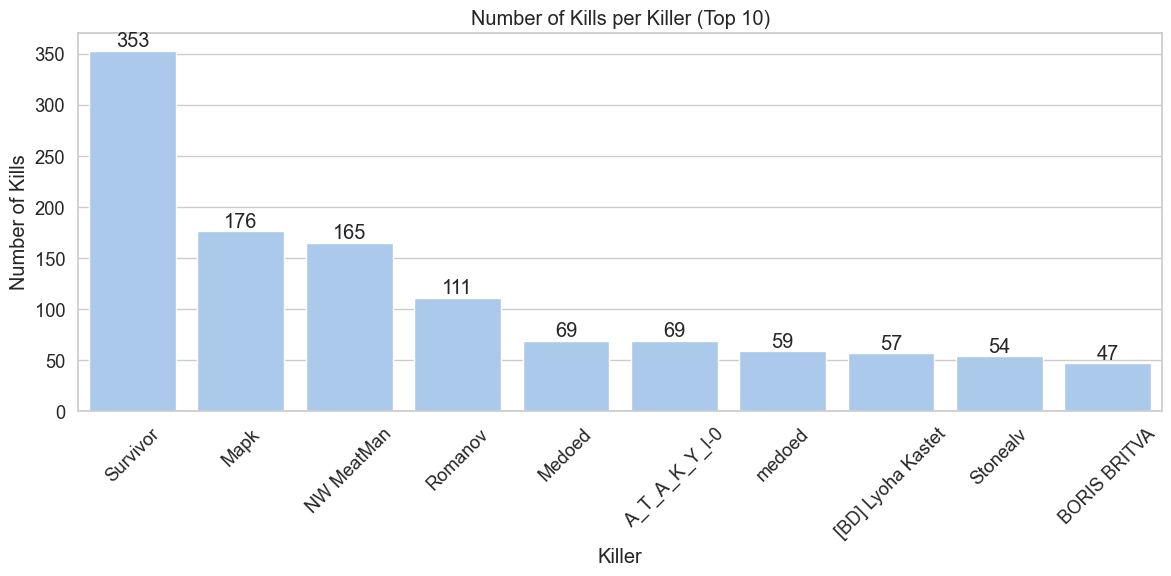

In [8]:
# Create a count plot of the number of kills per killer (top 10)
plt.figure(figsize=(12, 6))
top_10_killers = df['Killer'].value_counts().head(10).index
sns.countplot(data=df[df['Killer'].isin(top_10_killers)], x='Killer', order=top_10_killers)
plt.title('Number of Kills per Killer (Top 10)')
plt.xlabel('Killer')
plt.ylabel('Number of Kills')
plt.xticks(rotation=45)

# Add labels to the bars
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%d', label_type='edge')

plt.tight_layout()
plt.show()


## Death per Player

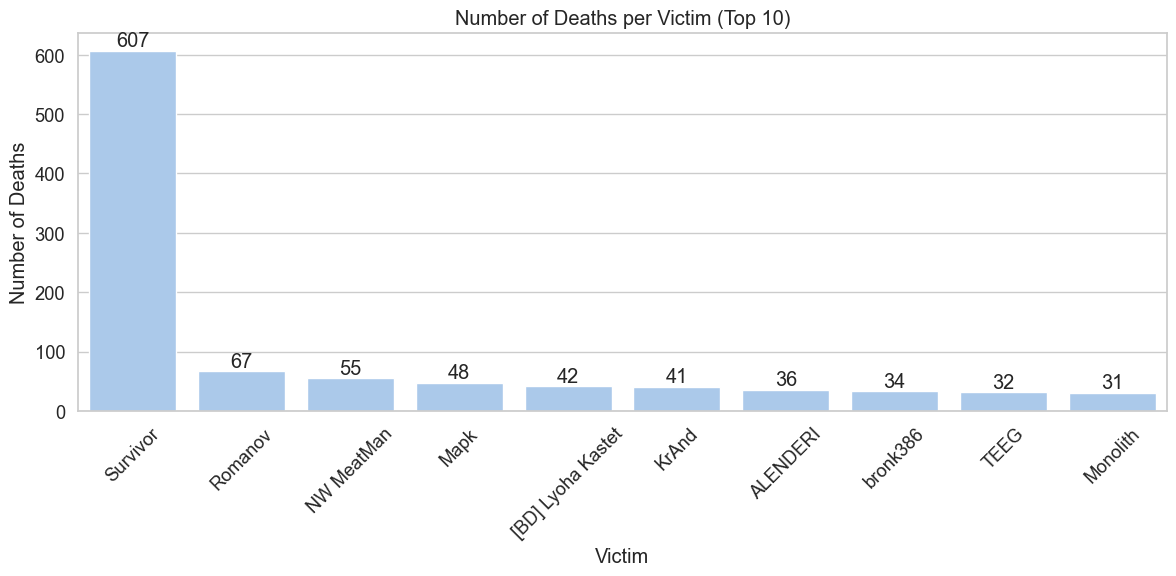

In [9]:
# Create a count plot of the number of deaths per victim (top 10)
plt.figure(figsize=(12, 6))
top_10_victims = df['Victim'].value_counts().head(10).index
sns.countplot(data=df[df['Victim'].isin(top_10_victims)], x='Victim', order=top_10_victims)
plt.title('Number of Deaths per Victim (Top 10)')
plt.xlabel('Victim')
plt.ylabel('Number of Deaths')
plt.xticks(rotation=45)

# Add labels to the bars
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%d', label_type='edge')

plt.tight_layout()
plt.show()

## K/D

In [10]:
import numpy as np  # for simple mathematics

# Code for Df with Kills und Deaths per Player
all_players = pd.concat([df['Killer'], df['Victim']]).unique()
kd_df = pd.DataFrame({
    'Name': all_players,
    'Kills': pd.Series(all_players).map(df['Killer'].value_counts()).fillna(0).astype(int),
    'Deaths': pd.Series(all_players).map(df['Victim'].value_counts()).fillna(0).astype(int)
})

# add KDR
kd_df['KDR'] = np.where(
    kd_df['Deaths'] > 0,  # Nur teilen, wenn Deaths > 0
    kd_df['Kills'] / kd_df['Deaths'],  # Kills/Deaths
    kd_df['Kills']  # Wenn Deaths=0, setze KDR = Kills
)

# round to 2 decimal numbers
kd_df['KDR'] = kd_df['KDR'].round(2).astype(float)

# sort the results
kd_df = kd_df.sort_values('Kills', ascending=False).reset_index(drop=True)

kd_df.head(25)

,Name,Kills,Deaths,KDR
0,Survivor,353,607,0.58
1,Mapk,176,48,3.67
2,NW MeatMan,165,55,3.00
3,Romanov,111,67,1.66
4,Medoed,69,27,2.56
5,A_T_A_K_Y_l-0,69,25,2.76
6,medoed,59,19,3.11
7,[BD] Lyoha Kastet,57,42,1.36
8,Stonealv,54,17,3.18
9,BORIS BRITVA,47,24,1.96


In [23]:
kd_buzz = kd_df[kd_df['Name'].str.contains('BuZz|Mampfo|Heiko Westermann', case=True)]
kd_buzz.reset_index(drop=True, inplace=True)
kd_buzz.head(10)

,Name,Kills,Deaths,KDR
0,[BuZz] taubenschreck,10,2,5.0
1,[BuZz] John Pork,7,5,1.4
2,Mampfo,5,0,5.0
3,[BuZz] Luca,4,1,4.0
4,Heiko Westermann,2,0,2.0
5,[BuZz] Bratan Joseph,2,0,2.0
6,[BuZz] Stepmotherlover,1,1,1.0
7,[BuZz] Tactical Teabagger,1,0,1.0
8,[BuZz] HW4 ??,0,1,0.0
9,[BuZz] taubenschreck (Survivor 6),0,1,0.0


## Greatest Enemy

In [12]:
# Calculate the killer who killed each victim the most times
most_frequent_killer_per_victim = df.groupby(['Victim', 'Killer']).size().reset_index(name='Kill Count')
most_frequent_killer_per_victim = most_frequent_killer_per_victim.loc[
    most_frequent_killer_per_victim.groupby('Victim')['Kill Count'].idxmax()
].reset_index(drop=True)

most_frequent_killer_per_victim = most_frequent_killer_per_victim.sort_values('Kill Count', ascending=False).reset_index(drop=True)

most_frequent_killer_per_victim.head(10)

,Victim,Killer,Kill Count
0,Survivor,Survivor,61
1,Pauke,[BD] Lyoha Kastet,6
2,Sattobi98,Mapk,5
3,KrAnd,Mapk,5
4,ALENDERI,Survivor,5
5,Cateye,James,5
6,Abakymov,evh,5
7,radik,Survivor,4
8,Czarny,Mapk,4
9,bronk386,Mapk,4


## Kills by Meter

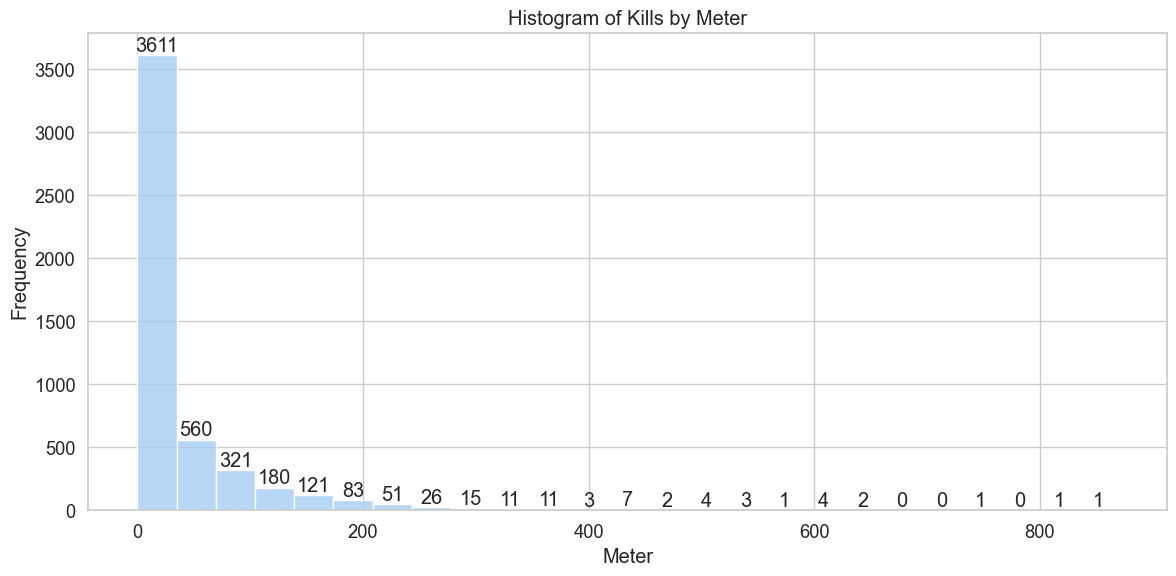

In [13]:
# Create a histogram for the Meter column with automatic bins
plt.figure(figsize=(12, 6))
ax = sns.histplot(data=df, x='Meter', bins=25, kde=False)
plt.title('Histogram of Kills by Meter')
plt.xlabel('Meter')
plt.ylabel('Frequency')

# Add labels to the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge')

plt.tight_layout()
plt.show()


In [48]:
# aggregate the data in bin (meter, count)
meter_bins = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
# create a new column 'Meter_Bin' with the bin number
df['Meter_Bin'] = pd.cut(df['Meter'], bins=meter_bins, right=False)
# count the number of kills in each bin
df['Meter_Bin'] = df['Meter_Bin'].astype(str)
# count the number of kills in each bin
df['Count'] = 1
df_meter_bins = df.groupby('Meter_Bin')['Count'].sum().reset_index()
# sort by count
df_meter_bins = df_meter_bins.sort_values(by='Count', ascending=False).reset_index(drop=True)

df_meter_bins

,Meter_Bin,Count
0,"[0, 50)",3923
1,"[50, 100)",534
2,"[100, 150)",248
3,"[150, 200)",155
4,"[200, 250)",70
5,"[250, 300)",33
6,"[300, 350)",16
7,"[350, 400)",13
8,"[400, 450)",8
9,"[600, 650)",5


### Leaderboard for longes kills

In [14]:
# table of the top 10 kills by meter
top_10_kills_by_meter = df.nlargest(10, 'Meter')
top_10_kills_by_meter.reset_index(drop=True, inplace=True)
top_10_kills_by_meter


,Victim,Meter,Weapon,Killer,date,time
0,Reinhart Beinhart,868.96,DMR,Darkness,2025-03-24,18:38:25
1,Mr.Freeman,812.79,DMR,[BuZz] John Pork,2025-04-04,18:57:39
2,Edicson,737.03,M70 Tundra,NW MeatMan,2024-11-25,19:43:39
3,Survivor,656.28,VS-89,Survivor,2025-04-06,03:09:18
4,FOneks,640.85,VSD,PipaFria,2024-11-20,21:11:02
5,incapablos,619.83,M70 Tundra,4yga,2024-12-01,20:32:20
6,Valkone,617.67,DMR,NW MeatMan,2024-11-16,10:51:38
7,Survivor,616.85,M70 Tundra,ROMAN,2024-10-26,21:14:19
8,pork,604.89,M70 Tundra,chste043,2025-02-22,17:24:00
9,DIRTY PICKLE,588.02,CR-527,Survivor,2024-11-23,21:40:08


### Kill distance by weapon

In [15]:
# Average kill distance per Weapon
average_kill_distance = df.groupby('Weapon')['Meter'].mean().reset_index()
average_kill_distance.rename(columns={'tmp': 'Weapon', 'Meter': 'Average Distance (m)'}, inplace=True)
average_kill_distance.sort_values(by='Average Distance (m)', ascending=False, inplace=True,)
average_kill_distance['Average Distance (m)'] = average_kill_distance['Average Distance (m)'].round(2)
average_kill_distance.reset_index(drop=True, inplace=True)


# add max kill distance to the table
max_kill_distance = df.groupby('Weapon')['Meter'].max().reset_index()
max_kill_distance.rename(columns={'tmp': 'Weapon', 'Meter': 'Max Distance (m)'}, inplace=True)
max_kill_distance.sort_values(by='Max Distance (m)', ascending=False, inplace=True)
max_kill_distance.reset_index(drop=True, inplace=True)
# merge the two tables
average_kill_distance = pd.merge(average_kill_distance, max_kill_distance, on='Weapon')

average_kill_distance.head(10)

,Weapon,Average Distance (m),Max Distance (m)
0,CR-550 Savanna,134.89,442.75
1,M70 Tundra,126.58,737.03
2,VS-89,107.73,656.28
3,VSD,99.52,640.85
4,Blaze,87.47,497.17
5,Mosin 91/30,75.65,440.96
6,DMR,72.21,868.96
7,Pioneer,57.13,176.86
8,SSG 82,56.65,182.09
9,CR-527,55.16,588.02


## Top Weapons

In [16]:
# all kills with weapon "Potato"
potato_kills = df[df['Weapon'] == 'Potato']
potato_kills

,Victim,Meter,Weapon,Killer,date,time
305,B1100110011,0.89,Potato,[Gr0b]youGamElling!0.o,2025-04-02,19:50:59


In [31]:
df

,Victim,Meter,Weapon,Killer,date,time,hour
0,Romanov,4.04,LAR,DuDeKh,2025-04-12,18:33:43,18
1,ItzKrogzy,5.10,M4-A1,M,2025-04-12,20:39:18,20
2,Insane,8.61,VSD,BORIS BRITVA,2025-04-12,20:49:39,20
3,DerBube,4.42,LAR,4fun,2025-04-12,20:52:26,20
4,Abrahamsen,23.21,KA-M,MEDOED,2025-04-12,21:02:59,21
...,...,...,...,...,...,...,...
5174,Toshiks,240.38,Blaze,Scorpion,2024-09-17,16:46:03,16
5175,Jimmie Grinney,207.17,CR-550 Savanna,Klase,2024-09-17,17:31:57,17
5176,[CCCP]kroLik,0.87,USG-45,Quess who?,2024-09-17,17:36:29,17
5177,prime,5.58,KA-74,[adidas]son of palych,2024-09-17,17:55:56,17


In [32]:
# add "is_gun" column from weapon_df to the df
# df columns = Victim	Meter	Weapon	Killer	date	time	hour
# weapon_df columns = Weapon	is_gun
# merge the two dataframes on the column Weapon
df_weapons = pd.merge(df, weapons_df[['Weapon', 'is_gun']], on='Weapon', how='left')
df_weapons

,Victim,Meter,Weapon,Killer,date,time,hour,is_gun
0,Romanov,4.04,LAR,DuDeKh,2025-04-12,18:33:43,18,True
1,ItzKrogzy,5.10,M4-A1,M,2025-04-12,20:39:18,20,True
2,Insane,8.61,VSD,BORIS BRITVA,2025-04-12,20:49:39,20,True
3,DerBube,4.42,LAR,4fun,2025-04-12,20:52:26,20,True
4,Abrahamsen,23.21,KA-M,MEDOED,2025-04-12,21:02:59,21,True
...,...,...,...,...,...,...,...,...
5014,Toshiks,240.38,Blaze,Scorpion,2024-09-17,16:46:03,16,True
5015,Jimmie Grinney,207.17,CR-550 Savanna,Klase,2024-09-17,17:31:57,17,True
5016,[CCCP]kroLik,0.87,USG-45,Quess who?,2024-09-17,17:36:29,17,True
5017,prime,5.58,KA-74,[adidas]son of palych,2024-09-17,17:55:56,17,True


### Top weapons by kill count

In [17]:
# Top weapons by kill count with average distance
top_weapons_by_kill_count = df['Weapon'].value_counts().reset_index()
top_weapons_by_kill_count.columns = ['Weapon', 'Kill Count']
top_weapons_by_kill_count.reset_index(drop=True, inplace=True)

# Merge with average kill distance
top_weapons_with_avg_distance = top_weapons_by_kill_count.merge(
    average_kill_distance, on='Weapon', how='left'
)

# Sort by kill count and display the top 10
top_weapons_with_avg_distance.sort_values(by='Kill Count', ascending=False, inplace=True)
top_weapons_with_avg_distance.head(10)


,Weapon,Kill Count,Average Distance (m),Max Distance (m)
0,KA-74,470,13.85,169.67
1,DMR,328,72.21,868.96
2,M70 Tundra,296,126.58,737.03
3,M4-A1,276,26.32,383.80
4,KA-M,250,14.06,148.08
5,Blaze,188,87.47,497.17
6,VSD,185,99.52,640.85
7,LAR,183,44.76,236.36
8,BK-43,180,7.75,36.86
9,KA-101,151,15.12,132.10


In [39]:
# top weapons by kill count where is_gun = False
top_weapons_by_kill_count_no_gun = df_weapons[df_weapons['is_gun'] == False]['Weapon'].value_counts().reset_index()
top_weapons_by_kill_count_no_gun.columns = ['Weapon', 'Kill Count']
top_weapons_by_kill_count_no_gun.reset_index(drop=True, inplace=True)

# set max rows = default
pd.set_option('display.max_rows', None)

top_weapons_by_kill_count_no_gun.head(20)

,Weapon,Kill Count
0,Hatchet,48
1,Steak Knife,33
2,Glow Stick,29
3,Hunting Knife,16
4,Bandage,14
5,Baseball Bat,12
6,Farming Hoe,11
7,Sickle,11
8,Cleaver,10
9,Combat Knife,8


## Kills per hour of the day

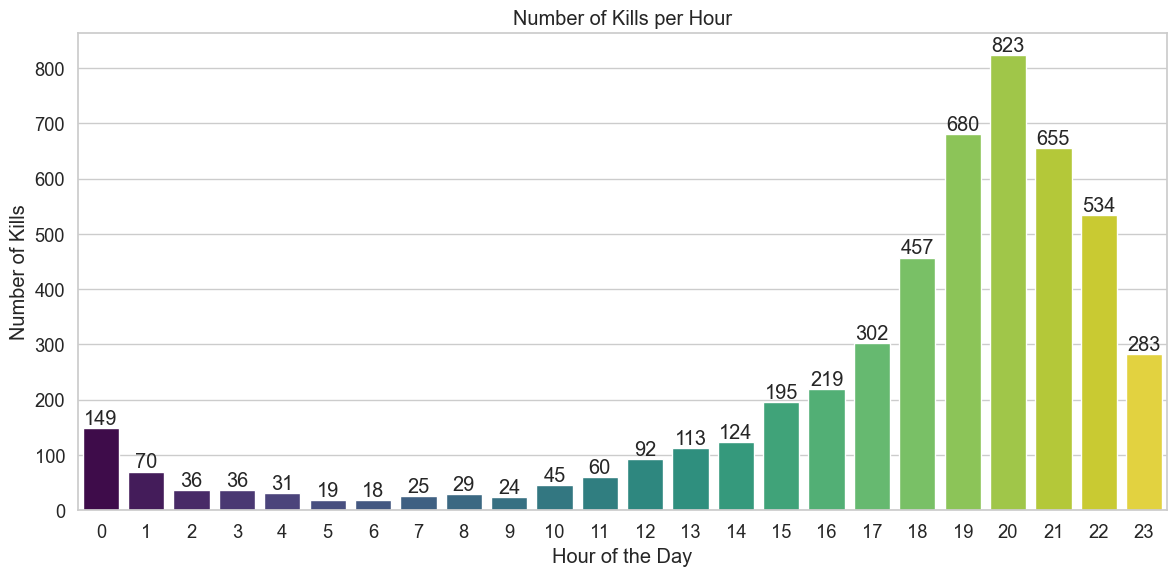

In [18]:
# visualize the time and frequency of kills per hour
plt.figure(figsize=(12, 6))
# Convert the 'time' column to datetime format for easier manipulation
df['time'] = pd.to_datetime(df['time'], format='%H:%M:%S').dt.time
# Create a new column for the hour of the kill
df['hour'] = pd.to_datetime(df['time'], format='%H:%M:%S').dt.hour
# Create a count plot of the number of kills per hour
sns.countplot(data=df, x='hour',hue='hour', palette='viridis', legend=False)
plt.title('Number of Kills per Hour') 
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Kills')
# Add labels to the bars
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%d', label_type='edge')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## BuZz Statistics

In [19]:
# top 5 killer with the text "BuZz" in their name
top_5_killers_buzz = df[df['Killer'].str.contains('BuZz|Mampfo', case=False)]['Killer'].value_counts().head(5).reset_index()
top_5_killers_buzz.columns = ['Killer', 'Kill Count']
top_5_killers_buzz.reset_index(drop=True, inplace=True)
top_5_killers_buzz.head(5)

,Killer,Kill Count
0,[BuZz] taubenschreck,10
1,[BuZz] John Pork,7
2,Mampfo,5
3,[BuZz] Luca,4
4,[BuZz] Bratan Joseph,2


In [20]:
# list all kills with the text "BuZz" in their name
kills_buzz = df[df['Killer'].str.contains('BuZz|Mampfo', case=False)]
kills_buzz.reset_index(drop=True, inplace=True)
# reorder the columns
kills_buzz = kills_buzz[['Killer', 'Victim', 'Weapon', 'Meter', 'date', 'time']]
kills_buzz.head(50)

,Killer,Victim,Weapon,Meter,date,time
0,[BuZz] taubenschreck,DonCorleone,M4-A1,43.51,2025-04-12,21:26:50
1,[BuZz] taubenschreck,V,M4-A1,3.38,2025-04-12,21:27:01
2,[BuZz] taubenschreck,McLovin,M4-A1,4.05,2025-04-12,21:27:04
3,[BuZz] Tactical Teabagger,BiBa,AUR AX,20.73,2025-04-17,21:43:21
4,[BuZz] taubenschreck,Kuma,DMR,6.71,2025-04-07,18:20:15
5,[BuZz] taubenschreck,Devimon,DMR,171.96,2025-04-07,19:50:15
6,[BuZz] taubenschreck,DeadFox77,DMR,240.18,2025-04-07,19:51:16
7,[BuZz] Luca,Angemon,VSD,34.64,2025-04-07,20:27:06
8,[BuZz] Luca,Stonealv,VSD,33.33,2025-04-07,20:27:12
9,[BuZz] Stepmotherlover,DeadFox77,AUR AX,52.23,2025-04-07,20:57:09


In [21]:
# Aggregate the weapons by the number of kills
weapon_kill_counts = df['Weapon'].value_counts().reset_index()
weapon_kill_counts.columns = ['Weapon', 'Kill Count']



# add a column "is gun" and set all values to false
weapon_kill_counts['is_gun'] = False

weapon_kill_counts

# export to xlsx
weapon_kill_counts.to_excel('weapons.xlsx', index=False)

In [22]:
# no row limit in output
pd.set_option('display.max_rows', None)
weapon_kill_counts

,Weapon,Kill Count,is_gun
0,KA-74,470,False
1,DMR,328,False
2,M70 Tundra,296,False
3,M4-A1,276,False
4,KA-M,250,False
5,Blaze,188,False
6,VSD,185,False
7,LAR,183,False
8,BK-43,180,False
9,KA-101,151,False
